#### HH model

In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt

##### Voltage-dependent paramaters

In [86]:
def alphah(v):
    # input: v: membrane potential in mV
    # output: rate: rate constant in ms^-1
    theta = (v + 70) / 20
    rate = 0.07 * math.exp(-theta)
    return rate

def alphah_2(v):
    # input: v: membrane potential in mV
    # output: rate: rate constant in ms^-1
    theta = (v + 70) / 20
    rate = 0.07 * math.exp(-theta)
    return 2 * rate

def betah(v):
    # input: input: v: membrane potential in mV
    # output: rate: rate constant in ms^-1
    theta = (v + 40) / 10
    rate = 1.0 / (1 + math.exp(-theta))
    return rate

def alpham(v):
    theta = (v + 45) / 10
    if 1 - math.exp(-theta) != 0:
        rate = 1.0 * theta / (1 - math.exp(-theta))
    else:
        rate = 1.0
    return rate

def betam(v):
    theta = (v + 70) / 18
    rate= 4.0 * math.exp(-theta)
    return rate

def alphan(v):
    theta = (v + 60) / 10
    if 1 - math.exp(-theta) != 0:
        rate = 0.1 * theta / (1 - math.exp(-theta))
    else:
        rate = 0.1
    return rate

def betan(v):
    theta = (v + 70) / 80
    rate = 0.125 * math.exp(-theta)
    return rate

### HH model

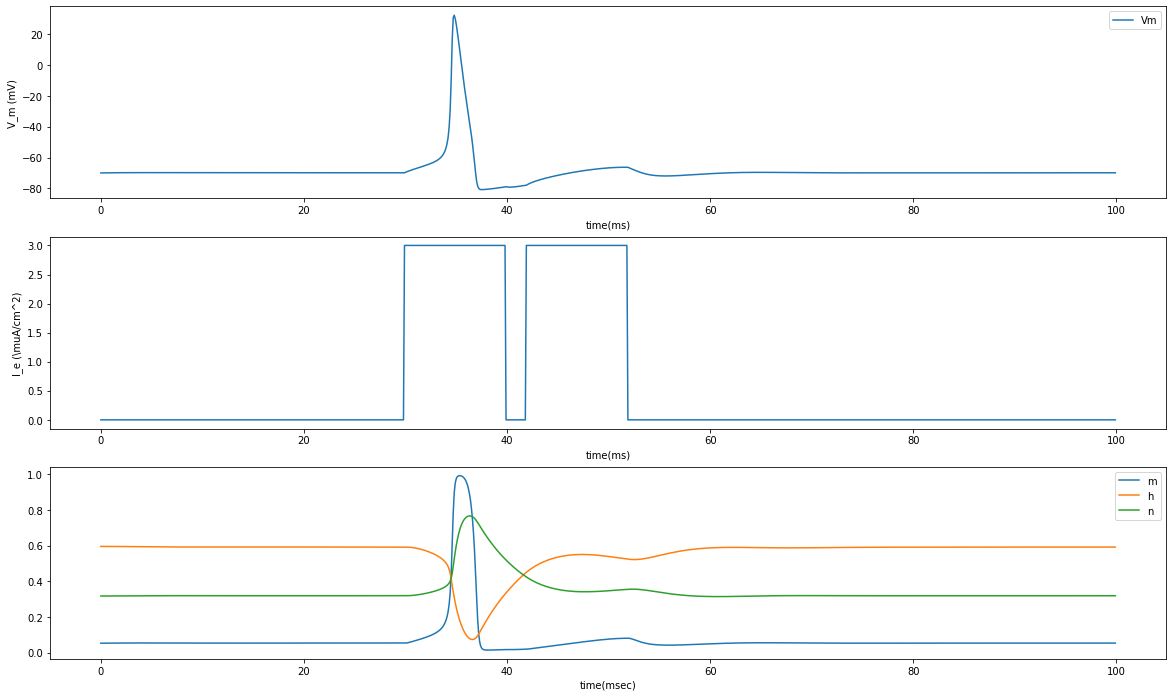

In [87]:
# Numerically integrated with an Exponential Euler Scheme 
"""
Units:
voltage is in millivolts (mV)
current is in microamperes (uA)
capacitance is in microfarads (uF)
conductance is in millisiemens (mS)
area is in centimeters squared (cm^2)
time is in milliseconds (ms)
"""

# Area of cell
A = 1  #cm^2
# membrane capacitance per unit area:
C = 1.0      # uF/cm^2
# max possible Na+ conductance per unit area:
gNabar = 120 # mS/cm^2
# max possible K+ conductance per unit area:
gKbar = 36   # mS/cm^2
# leakage conductance per unit area:
gLbar = 0.3  # mS/cm^2
# Na+ equilibrium potential:
ENa = 45   #   mV
# K+ equilibrium potential:
EK = -82   #   mV
# leakage channel reversal potential:
EL = -59   #   mV

# initialize time step and experiment duration:
dt = 0.1     # time step duration (ms)
tmax = 100   # duration of experiment (ms)

# total number of time steps in the experiment:
niter = math.ceil(tmax/dt)

# initialize arrays that hold data for plotting:
m_plot = np.zeros(niter)
h_plot = np.zeros(niter)
h_inf = np.zeros(niter)
n_plot = np.zeros(niter)
V_plot = np.zeros(niter)
V_inf = np.zeros(niter)
t_plot = np.arange(0, tmax, dt)

# voltage just at t=0: initial condition
vstart = -70
V_plot[0] = vstart
# In fact we are assuming V was at -70 before experiment to set m,h,n to their steady state values at -70

# minf, hinf, ninf at -70  for initial condition
m_plot[0] = alpham(V_plot[0]) / (alpham(V_plot[0]) + betam(V_plot[0]))
h_plot[0] = alphah(V_plot[0]) / (alphah(V_plot[0]) + betah(V_plot[0]))
n_plot[0] = alphan(V_plot[0]) / (alphan(V_plot[0]) + betan(V_plot[0]))

# Current injected
Ie = np.zeros(niter)
# square pulse of current starts at 30 ms and ends at 40 ms
Ie[30 * 10 - 1: 40 * 10 - 1] = 3 # uA/cm^2
Ie[42 * 10 - 1: 52 * 10 - 1] = 3

# Main for loop to numerically integrate the HH model 
for k in range(niter - 1):
    # taus for m,h,n
    tau_m = 1 / (alpham(V_plot[k]) + betam(V_plot[k]))
    tau_h = 1 / (alphah(V_plot[k]) + betah(V_plot[k]))
    tau_n = 1 / (alphan(V_plot[k]) + betan(V_plot[k]))
  
    # Steady state values for m, h, n
    m_inf = alpham(V_plot[k])/(alpham(V_plot[k])+betam(V_plot[k]))
    h_inf[k] = alphah(V_plot[k])/(alphah(V_plot[k])+betah(V_plot[k]))
    n_inf = alphan(V_plot[k])/(alphan(V_plot[k])+betan(V_plot[k]))  
  
    # Update m, h, and n using the Exponential-Euler method
    m_plot[k + 1] = m_inf + (m_plot[k] - m_inf) * math.exp(-dt/tau_m) 
    h_plot[k + 1] = h_inf[k] + (h_plot[k] - h_inf[k]) * math.exp(-dt/tau_h)
    n_plot[k + 1] = n_inf + (n_plot[k] - n_inf) * math.exp(-dt/tau_n)
  
    # Update conductances
    gNa = gNabar * math.pow(m_plot[k + 1], 3) * h_plot[k + 1]    # sodium conductance
    gK = gKbar * math.pow(n_plot[k + 1], 4)                        # potassium conductance
    g = gNa + gK + gLbar                                         # total conductance
    gE = gNa * ENa + gK * EK + gLbar * EL                        # gE=g*E
    
    # update vinf
    V_inf[k] = (gE + Ie[k] / A) / g
    # update tauv
    tau_V = C / g
    # exponential euler for updating membrane potential
    V_plot[k + 1] = V_inf[k] + (V_plot[k] - V_inf[k])* math.exp(-dt/tau_V)


# plt.figure(figsize=(20, 12))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
ax1.plot(t_plot, V_plot, label='Vm')
ax1.set_xlabel('time(ms)')
ax1.set_ylabel('V_m (mV)')
ax1.legend()

ax2.plot(t_plot, Ie)
ax2.set_xlabel('time(ms)')
ax2.set_ylabel('I_e (\muA/cm^2)')

ax3.plot(t_plot, m_plot, label = 'm')
ax3.plot(t_plot, h_plot, label = 'h')
ax3.plot(t_plot, n_plot, label = 'n')
ax3.set_xlabel('time(msec)')
ax3.legend()

plt.show()

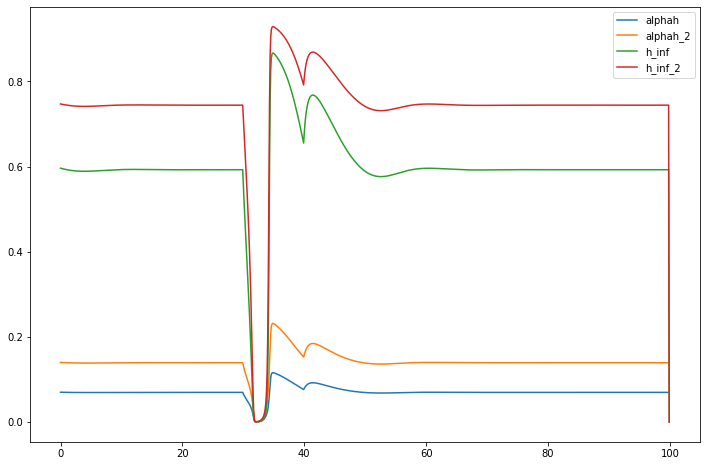

In [50]:
alphah_plot = np.zeros(niter)
for i in range(niter):
    alphah_plot[i] = alphah(V_plot[i])
plt.figure(figsize=(12, 8))
plt.plot(t_plot, alphah_plot, label='alphah')
plt.plot(t_plot, alphah_plot*2, label='alphah_2')
plt.plot(t_plot, h_inf, label='h_inf')
plt.plot(t_plot, h_inf_2, label='h_inf_2')

plt.legend()
plt.show()


#### Hyperpolarization

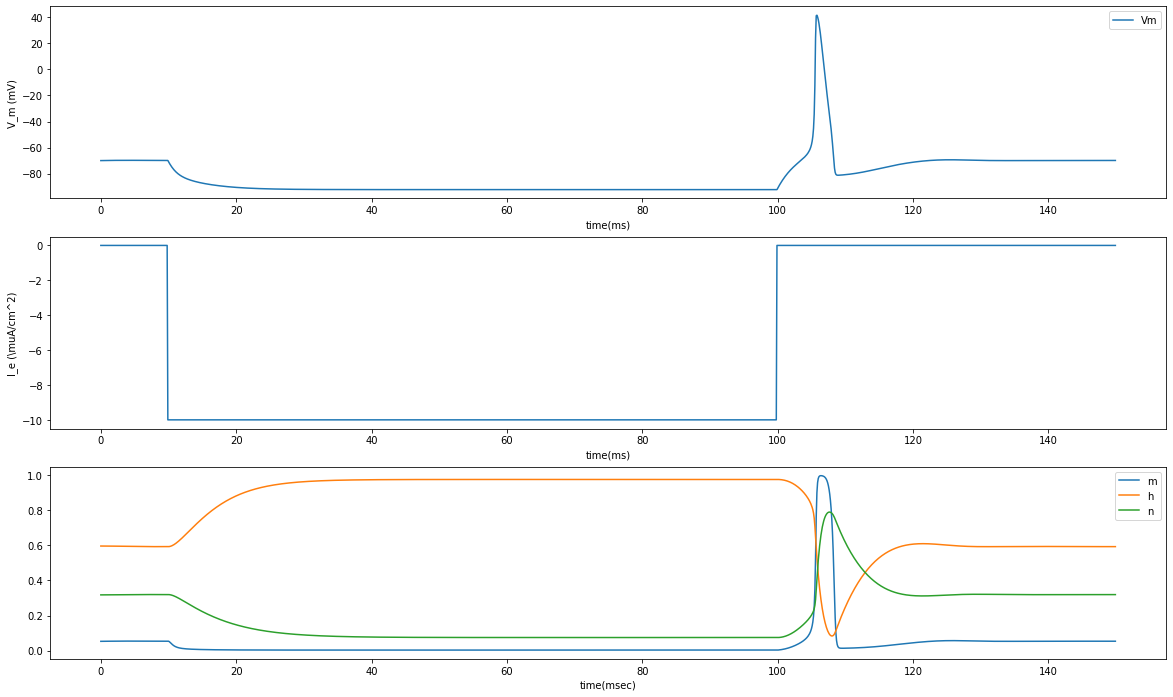

In [88]:
# Area of cell
A = 1  #cm^2
# membrane capacitance per unit area:
C = 1.0      # uF/cm^2
# max possible Na+ conductance per unit area:
gNabar = 120 # mS/cm^2
# max possible K+ conductance per unit area:
gKbar = 36   # mS/cm^2
# leakage conductance per unit area:
gLbar = 0.3  # mS/cm^2
# Na+ equilibrium potential:
ENa = 45   #   mV
# K+ equilibrium potential:
EK = -82   #   mV
# leakage channel reversal potential:
EL = -59   #   mV

# initialize time step and experiment duration:
dt = 0.1     # time step duration (ms)
tmax = 150   # duration of experiment (ms)

# total number of time steps in the experiment:
niter = math.ceil(tmax/dt)

# initialize arrays that hold data for plotting:
m_plot = np.zeros(niter)
h_plot = np.zeros(niter)
h_inf = np.zeros(niter)
n_plot = np.zeros(niter)
V_plot = np.zeros(niter)
V_inf = np.zeros(niter)
t_plot = np.arange(0, tmax, dt)

# voltage just at t=0: initial condition
vstart = -70
V_plot[0] = vstart
# In fact we are assuming V was at -70 before experiment to set m,h,n to their steady state values at -70

# minf, hinf, ninf at -70  for initial condition
m_plot[0] = alpham(V_plot[0]) / (alpham(V_plot[0]) + betam(V_plot[0]))
h_plot[0] = alphah(V_plot[0]) / (alphah(V_plot[0]) + betah(V_plot[0]))
n_plot[0] = alphan(V_plot[0]) / (alphan(V_plot[0]) + betan(V_plot[0]))

# Current injected
Ie = np.zeros(niter)
# square pulse of current starts at 30 ms and ends at 40 ms
Ie[10 * 10 - 1: 100 * 10 - 1] = -10

# Main for loop to numerically integrate the HH model 
for k in range(niter - 1):
    # taus for m,h,n
    tau_m = 1 / (alpham(V_plot[k]) + betam(V_plot[k]))
    tau_h = 1 / (alphah(V_plot[k]) + betah(V_plot[k]))
    tau_n = 1 / (alphan(V_plot[k]) + betan(V_plot[k]))
  
    # Steady state values for m, h, n
    m_inf = alpham(V_plot[k])/(alpham(V_plot[k])+betam(V_plot[k]))
    h_inf[k] = alphah(V_plot[k])/(alphah(V_plot[k])+betah(V_plot[k]))
    n_inf = alphan(V_plot[k])/(alphan(V_plot[k])+betan(V_plot[k]))  
  
    # Update m, h, and n using the Exponential-Euler method
    m_plot[k + 1] = m_inf + (m_plot[k] - m_inf) * math.exp(-dt/tau_m) 
    h_plot[k + 1] = h_inf[k] + (h_plot[k] - h_inf[k]) * math.exp(-dt/tau_h)
    n_plot[k + 1] = n_inf + (n_plot[k] - n_inf) * math.exp(-dt/tau_n)
  
    # Update conductances
    gNa = gNabar * math.pow(m_plot[k + 1], 3) * h_plot[k + 1]    # sodium conductance
    gK = gKbar * math.pow(n_plot[k + 1], 4)                        # potassium conductance
    g = gNa + gK + gLbar                                         # total conductance
    gE = gNa * ENa + gK * EK + gLbar * EL                        # gE=g*E
    
    # update vinf
    V_inf[k] = (gE + Ie[k] / A) / g
    # update tauv
    tau_V = C / g
    # exponential euler for updating membrane potential
    V_plot[k + 1] = V_inf[k] + (V_plot[k] - V_inf[k])* math.exp(-dt/tau_V)


# plt.figure(figsize=(20, 12))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12))
ax1.plot(t_plot, V_plot, label='Vm')
ax1.set_xlabel('time(ms)')
ax1.set_ylabel('V_m (mV)')
ax1.legend()

ax2.plot(t_plot, Ie)
ax2.set_xlabel('time(ms)')
ax2.set_ylabel('I_e (\muA/cm^2)')

ax3.plot(t_plot, m_plot, label = 'm')
ax3.plot(t_plot, h_plot, label = 'h')
ax3.plot(t_plot, n_plot, label = 'n')
ax3.set_xlabel('time(msec)')
ax3.legend()

plt.show()